# Character Level CNN

In [17]:
import Corpus.gutenberg as corpus
from TextPreprocess.Tokenizer.Stanford import tokenize
from Utils.visual import hist, tally, plot
from Utils.debug import dump
from Utils.generator import sliding_window_random_access, transform
from Utils.FS.file import save, load
from Utils.keras import compact_embedding
from Utils.misc import batch
from Utils.indexer import build_index, index_2_one_hot
from keras.preprocessing.sequence import pad_sequences
from keras_tqdm import TQDMNotebookCallback
import numpy as np

In [2]:
from nltk.corpus import gutenberg
data = gutenberg.raw(['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt'])

In [3]:
data = data[:len(data)]

In [4]:
def char_generator():
    for char in data:
        yield char

In [5]:
s2i, i2s, size = build_index(char_generator())

In [6]:
#MAX_SEQ_LENGTH = max([len(word) for word in data])
SEQ_LENGTH = 32

In [7]:
NUM_SYMBOL = size
NUM_SYMBOL

82

In [8]:
NUM_SAMPLE = len(data)
NUM_SAMPLE

2026385

In [9]:
gen = {}
size = {}
gen['train'], gen['test'], size['train'], size['test'] = sliding_window_random_access(data, SEQ_LENGTH + 1)
print(next(sample_generator(gen['train'], 2))[0].shape)
print(next(sample_generator(gen['test'], 2))[1].shape)

Training data size: 1621082
Testing data size: 405271


NameError: name 'sample_generator' is not defined

In [ ]:
from keras.callbacks import Callback, ModelCheckpoint
def testing(model):
    seed = """Your child comes home and presents you with a drawing of your house. There's a blue house, a yellow sun, and a green sky. You admire their handiwork and then gently ask why the sky is green. Shouldn't it be blue? Most teachers and parents would have the same reaction, but before you speak, stop! That innocent little comment carries a powerful punch. Unbeknownst to you, you are about to squelch your child's natural developing creativity.
Everyone has the ability to be creative, however, Professor of Biology and neurobiologist Erin Clabough Ph.D. writes that "creativity can be easily crushed by goals imposed by others." Not everyone needs to see the world in the same light- and they shouldn't. Before you mention that sky should be blue, consider your reasons carefully. Your child can see that a sky is blue, but in their world it isn't. Allow them the freedom to be creative. Creativity fosters critical thinking and problem solving skills. It helps people to deal with stress and adapt to changes.
"""
    for i in range(500):
        seed = seed + decode_word(model.predict(np.array([batch(s2i,seed[-SEQ_LENGTH:])]))[0])[0]
        
    print(seed)

    seed = """Your child comes home and presents you with a drawing of your house. There's a blue house, a yellow sun, and a green sky. You admire their handiwork and then gently ask why the sky is green. Shouldn't it be blue? Most teachers and parents would have the same reaction, but before you speak, stop! That innocent little comment carries a powerful punch. Unbeknownst to you, you are about to squelch your child's natural developing creativity.
Everyone has the ability to be creative, however, Professor of Biology and neurobiologist Erin Clabough Ph.D. writes that "creativity can be easily crushed by goals imposed by others." Not everyone needs to see the world in the same light- and they shouldn't. Before you mention that sky should be blue, consider your reasons carefully. Your child can see that a sky is blue, but in their world it isn't. Allow them the freedom to be creative. Creativity fosters critical thinking and problem solving skills. It helps people to deal with stress and adapt to changes.
"""
    for i in range(500):
        seed = seed + decode_word_2(model.predict(np.array([batch(s2i,seed[-SEQ_LENGTH:])]))[0])[0]
        
    print(seed)

    
class testSample(Callback):
    def on_epoch_end(self, batch, logs={}):
        testing(model)

In [34]:
from keras.models import load_model

model = load_model('./model/char_cnn_2.hdf5')

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 32, 82)            6724      
_________________________________________________________________
reshape_1 (Reshape)          (None, 32, 82, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 1, 256)        105216    
_________________________________________________________________
reshape_2 (Reshape)          (None, 28, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 28, 256)           295680    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               295680    
__________

In [36]:
weights = model.layers[3].get_weights() # conv layer

In [37]:
len(weights)

2

In [38]:
#filters = np.transpose(weights[0], (2,3,0,1))
filters.shape

(1, 256, 5, 82)

In [39]:
weights[1].shape # bias

(256,)

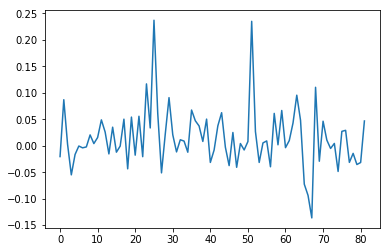

['C', 'B']


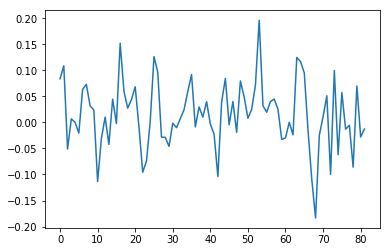

['j', '6']


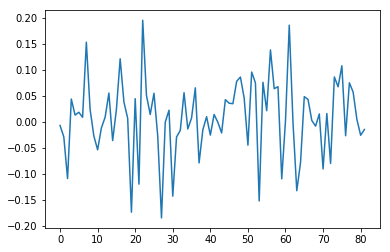

['U', '!']


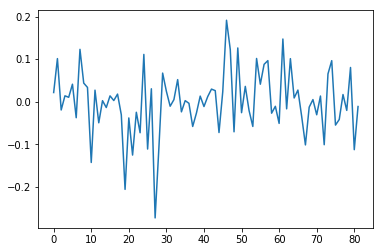

['-', '!']


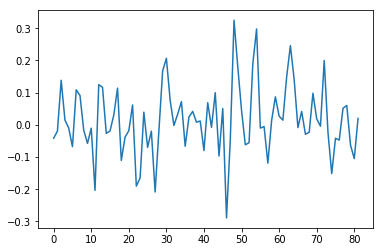

['S', 'k']


In [54]:
for i in range(5):
    plot(weights[0][i, :, 0, 0]) # first filter first char
    print(batch(i2s, weights[0][i, :, 0, 0].argsort()[-2:][::-1])) # char of highest weight

In [ ]:
batch(i2s, [np.argmax(filters[0,1][i]) for i in range(5)])

In [ ]:
batch(i2s, [np.argmax(filters[0,2][i]) for i in range(5)])

In [56]:
print(model.layers[3].input)
print(model.layers[3].output)

Tensor("reshape_1_1/Reshape:0", shape=(?, 32, 82, 1), dtype=float32)
Tensor("conv2d_1_1/mul_1:0", shape=(?, 28, 1, 256), dtype=float32)


In [84]:
from keras import backend as K

filter_index = 0  # can be any integer from 0 to 511, as there are 512 filters in that layer
#inp_seq = np.zeros((32, 82, 1))
# build a loss function that maximizes the activation
# of the nth filter of the layer considered
inp_seq = K.placeholder(shape=(1, 32,82,1))

layer_output = model.layers[3].output
loss = K.mean(layer_output[:, 0, 0, 0])

# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, inp_seq)[0]

# normalization trick: we normalize the gradient
#grads /= (K.sqrt(K.mean(K.square(grads))) + K.epsilon())

# this function returns the loss and grads given the input picture
iterate = K.function([inp_seq], [loss, grads])

TypeError: Can not convert a NoneType into a Tensor or Operation.

In [82]:
import numpy as np

# we start from a gray image with some noise

# run gradient ascent for 20 steps
for i in range(20):
    loss_value, grads_value = iterate([inp_seq])
    inp_seq += grads_value * step

NameError: name 'iterate' is not defined